# Convolutional Neural Network (CNN) Implementation [100 points]

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## 1. Load and preprocess the data

Load the training and test datasets, and preprocess the data by converting it to tensors and normalizing it.

In [2]:
def load_and_preprocess_data(batch_size=32):
    """
    Load the CIFAR-10 dataset and preprocess it by:
    - Converting images to tensors
    - Normalizing the data

    Args:
        batch_size (int): The batch size for training and testing.

    Returns:
        trainloader (DataLoader): DataLoader for the training dataset.
        testloader (DataLoader): DataLoader for the testing dataset.
    """
    # Define transformations for data augmentation and normalization
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),           # Randomly flip images horizontally
        transforms.RandomCrop(32, padding=4),        # Randomly crop images with padding
        transforms.ToTensor(),                       # Convert images to tensors
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize with CIFAR-10 mean/std
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),                       # Convert images to tensors
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize with CIFAR-10 mean/std
    ])

    # Load CIFAR-10 datasets
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Create DataLoaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)



    return trainloader, testloader

## 2. Split the data into training, validation, and test sets
Visualize a subset of the training dataset to get an understanding of what the data looks like.

In [3]:
def visualize_data(trainloader, num_images=6):
    """
    Visualize a subset of images from the training dataset.

    Args:
        trainloader (DataLoader): The DataLoader object for the training dataset.
        num_images (int): The number of images to visualize.

    Returns:
        None
    """
    # Implement your code
    # Get a batch of data from the DataLoader
    data_iter = iter(trainloader)
    images, labels = next(data_iter)

    # Define class labels (CIFAR-10)
    classes = [
        'airplane', 'automobile', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    # Select the number of images to visualize
    images_to_show = images[:num_images]
    labels_to_show = labels[:num_images]

    # Unnormalize the images for visualization
    images_to_show = images_to_show / 2 + 0.5  # Reverse normalization: (x - mean) / std -> x * std + mean

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for idx, ax in enumerate(axes):
        np_image = np.transpose(images_to_show[idx].numpy(), (1, 2, 0))  # Convert to (H, W, C) for plt.imshow
        ax.imshow(np_image)
        ax.set_title(classes[labels_to_show[idx]])
        ax.axis('off')

    plt.show()


## 3. Define the CNN class
**Implement the CNN model architecture using PyTorch, ensuring it aligns with the following design:**

#### Layer 1
* 3 x 3 conv. 96 ReLU (Input 32 x 32 RGB image, dropout = 0.2)
* 3 x 3 conv. 96 ReLU
---------------
#### Replace max pooling with CNN
* 3 x 3 conv. 96 ReLU, stride r = 2, dropout = 0.5
--------------
#### Layer 2
* 3 x 3 conv. 192 ReLU
* 3 x 3 conv. 192 ReLU
--------------
#### Replace max pooling with CNN
* 3 x 3 conv. 192, stride r = 2, dropout = 0.5
--------------
#### Layer 3
* 3 x 3 conv. 192 ReLU
-------------
#### Layer 4
* 1 x 1 conv. 192 ReLU
--------------
#### Layer 5
* 1 x 1 conv. 10 ReLU
--------------
#### Global averaging
-------------
#### Output layer
* 10 or 100-way softmax

In [4]:
class CNNModel(nn.Module):
    """
    Define a simple CNN model architecture for CIFAR-10 classification.
    """
    def __init__(self):
        super(CNNModel, self).__init__()
        num_classes=10
        # Implement your code
        # Layer 1: 3x3 conv with 96 filters, ReLU, dropout
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Replace max pooling with CNN (stride=2)
        self.layer1_pooling = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Layer 2: 3x3 conv with 192 filters, ReLU
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Replace max pooling with CNN (stride=2)
        self.layer2_pooling = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Layer 3: 3x3 conv with 192 filters, ReLU
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Layer 4: 1x1 conv with 192 filters, ReLU
        self.layer4 = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=1, stride=1),
            nn.ReLU()
        )
        
        # Layer 5: 1x1 conv with 10 filters, ReLU
        self.layer5 = nn.Sequential(
            nn.Conv2d(192, num_classes, kernel_size=1, stride=1),
            nn.ReLU()
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Output Layer: Softmax is applied during loss computation
        self.flatten = nn.Flatten()


    def forward(self, x):
        # Implement your code
         # Pass through layers
        x = self.layer1(x)
        x = self.layer1_pooling(x)
        x = self.layer2(x)
        x = self.layer2_pooling(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        
        # Flatten for fully connected output
        x = self.flatten(x)
        
        return x
        # Convolutional layers and fully connected layers
        # Define the forward pass through the model


## Train the model and track the training process
Train the model on the training set, while monitoring and logging training loss and accuracy throughout the epochs.

In [5]:
def train_model(model, trainloader, criterion, optimizer, device, epochs=10):
    """
    Train the CNN model.

    Args:
        model (nn.Module): The CNN model to train.
        trainloader (DataLoader): DataLoader for the training dataset.
        criterion (nn.Module): The loss function.
        optimizer (optim.Optimizer): The optimizer.
        epochs (int): Number of epochs to train.

    Returns:
        train_losses (list): List of training losses for each epoch.
        train_accuracies (list): List of training accuracies for each epoch.
    """
    # Implement your code
    # Move model to the specified device
    model.to(device)
    
    # Initialize lists to store loss and accuracy
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update loss
            running_loss += loss.item()

            # Update accuracy
            _, predicted = outputs.max(1)  # Get predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100.0 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Print progress
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies


## Evaluate the model and visualize model predictions
Evaluate the model on the test set to compute the accuracy and loss. Visualize predictions on a subset of the test set, showing the predicted labels and whether they are correct or incorrect.

In [6]:
def evaluate_model(model, testloader, device):
    """
    Evaluate the CNN model on the test dataset.

    Args:
        model (nn.Module): The trained CNN model.
        testloader (DataLoader): DataLoader for the test dataset.

    Returns:
        accuracy (float): Test accuracy of the model.
        loss (float): Test loss of the model.
    """
    # Implement your code

    # Move the model to the specified device
    model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize metrics
    total_loss = 0.0
    correct = 0
    total = 0
    
    # Define the loss function (same as used during training)
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in testloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update loss
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = outputs.max(1)  # Get class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Compute average loss and accuracy
    loss = total_loss / len(testloader)
    accuracy = 100.0 * correct / total

    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    
    return accuracy, loss


In [7]:
# Visualize model predictions
def visualize_predictions(model, testloader, device):
    """
    Visualize model predictions on a subset of the test dataset.

    Args:
        model (nn.Module): The trained CNN model.
        testloader (DataLoader): DataLoader for the test dataset.

    Returns:
        None
    """
    # Implement your code
    # Move model to the specified device
    model.to(device)
    model.eval()
    
    data_iter = iter(testloader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    # Display a subset of images
    images = images[:num_images]
    labels = labels[:num_images]
    predicted = predicted[:num_images]

    # Plot the images
    plt.figure(figsize=(12, 4))
    for idx in range(num_images):
        plt.subplot(1, num_images, idx + 1)
        
        # Unnormalize and prepare for display
        img = unnormalize(images[idx].cpu())
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format
        
        plt.imshow(img)
        color = "green" if predicted[idx] == labels[idx] else "red"
        plt.title(f"Pred: {predicted[idx].item()}\nTrue: {labels[idx].item()}", color=color)
        plt.axis("off")
    plt.show()

    
    # Unnormalize the images for display
    def unnormalize(img):
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2470, 0.2435, 0.2616]
    
        # Reverse normalization
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    
        # Clip values to [0, 1] range for imshow compatibility
        img = torch.clamp(img, 0, 1)
    
        return img

## Test your code

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


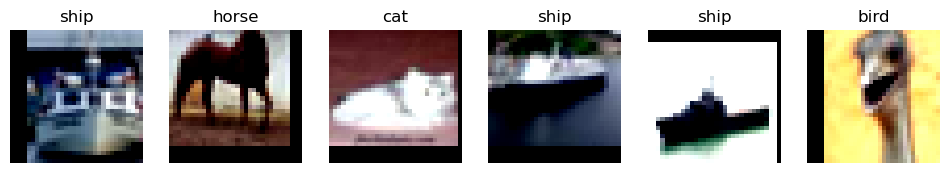

Epoch 1/10, Loss: 2.3027, Accuracy: 10.02%
Epoch 2/10, Loss: 2.3026, Accuracy: 10.00%
Epoch 3/10, Loss: 2.3026, Accuracy: 10.00%
Epoch 4/10, Loss: 2.3026, Accuracy: 10.00%
Epoch 5/10, Loss: 2.3026, Accuracy: 10.00%


In [ ]:

# Main function to validate the final result
def main():
    # Hyperparameters
    batch_size = 32              # Batch size for training
    learning_rate = 0.001        # Learning rate for optimizer
    epochs = 10                  # Number of training epochs
    weight_decay = 1e-5          # Weight decay (L2 regularization) to prevent overfitting

    # Check if GPU is available and use it
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    trainloader, testloader = load_and_preprocess_data(batch_size)

    # Visualize a subset of the data
    visualize_data(trainloader)

    # Initialize model, loss function, and optimizer
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, device, epochs=epochs)

    # Evaluate the model
    test_accuracy, test_loss = evaluate_model(model, testloader)

    # Visualize predictions
    visualize_predictions(model, testloader)


# Run the main function to validate the result
if __name__ == '__main__':
    main()

## Reference
[1] Springenberg, Jost Tobias, et al. "Striving for simplicity: The all convolutional net." arXiv preprint arXiv:1412.6806 (2014).